In [1]:
make_new_data = False
train_new_model = True
log_wandb = True

import numpy as np
np.random.seed(42)

import torch
torch.manual_seed(42)
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import pickle
import wandb
from sklearn.model_selection import train_test_split

from make_analogies_functions import *

num_samples = 100000 #each sample is a trio of images of which each comes in various forms (analogous transformations).
img_size = 10
pairs_per_task = 3
shape = "O" #I or L or O or T
all_images = []
method_names = ["Grown", "Moved", "Rotated", "Inverted", "Mirrored", "Close_Far Corners", "Close_Far Edges", "Stretched", "Shadows", "Gravity", "Count"]
seed_iteration = 0
data = []
rel_test_size  = 0.01
num_epochs = 60
batch_size = 512
learning_rate = 0.001
use_lr_scheduler = False

In [2]:
if make_new_data:
    for i in range(num_samples):    
        trios = []
        invalid_img = True
        while invalid_img:
            seed_iteration += 1
            np.random.seed(seed_iteration)

            #make 3 random images with Is
            trio = [create_image(img_size = img_size, shape = shape) for _ in range(pairs_per_task)]

            #sample parameters for analogies
            mirror_horizontal = np.random.choice([True, False])
            rotation_degree = np.random.choice([90, 180, 270])
            grow_left = np.random.choice([0,1])
            grow_right = np.random.choice([0,1])
            grow_top = np.random.choice([0,1])
            grow_bottom = np.random.choice([0,1])
            possible_growths = [(0, 1, 0, 0), (1, 0, 0, 0), (0, 0, 1, 0), (0, 0, 0, 1)]
            growth_index = np.random.choice(len(possible_growths))  # Choose an index from the list
            grow_left, grow_right, grow_top, grow_bottom = possible_growths[growth_index]
            possible_moves = [(0, 1), (1, 0), (-1, 0), (0, -1)]
            move_index = np.random.choice(len(possible_moves))  # Choose an index from the list
            move_vertical, move_horizontal = possible_moves[move_index]
            furthest_edge = np.random.choice([True, False])
            furthest_corner = np.random.choice([True, False])
            reverse_shadows = np.random.choice([True, False])
            gravity_direction = np.random.choice(["up","down","left","right"])
            count_left_right = np.random.choice([True, False])
            count_top_bottom = np.random.choice([True, False])

            # Generate analogies
            growths = [grow(img, grow_top, grow_bottom, grow_left, grow_right) for img in trio]
            moves = [move(img, move_horizontal, move_vertical)  for img in trio]
            rotations = [rotate_image(img, rotation_degree) for img in trio]
            inversions = [invert_colors(img)  for img in trio]
            mirrors = [mirror_image(img, horizontal=mirror_horizontal) for img in trio]
            corner_cells = [paint_corner(img, furthest_corner) for img in trio]
            edges = [paint_edge(img, furthest_edge) for img in trio]
            stretches = [stretch(img) for img in trio]
            shadows = [draw_shadows(img, reverse_shadows)  for img in trio]
            gravities = [gravity(img, gravity_direction)  for img in trio]
            counts = [count_pixels(img, count_left_right, count_top_bottom) for img in trio]
   
            #check whether images violate rules (original three include duplicates; initial transformations left the canvas)
            if np.array_equal(trio[0], trio[1]) or np.array_equal(trio[0], trio[2]) or np.array_equal(trio[1], trio[2]):
                invalid_img = True
            elif invalid_matrix(moves[0], img_size, img_size, 1):
                invalid_img = True
            elif invalid_matrix(growths[0], img_size, img_size, 1):
                invalid_img = True
            else:
                invalid_img = False

        
        transformed_trios = [growths, moves, rotations, inversions, mirrors, corner_cells, edges, stretches, shadows, gravities, counts]
        data.append([np.stack([trio, transformed_trio]) for transformed_trio in transformed_trios])

    data = np.array(data)

    long_data = data.reshape(data.shape[0]*data.shape[1], data.shape[2], data.shape[3], data.shape[4], data.shape[5])
    long_data = long_data.reshape(long_data.shape[0], long_data.shape[1] * long_data.shape[2], long_data.shape[3], long_data.shape[4])
    method_index = np.tile(method_names, num_samples)
    nonduplicates, unique_ind = np.unique(long_data, axis=0, return_index=True) #get rid of duplicated tasks; could be stricter by also considering flipped fewshot orders as duplicated
    method_index = method_index[unique_ind]
    print(f"{np.round(100*(1 - nonduplicates.shape[0] / long_data.shape[0]), 1)}% double trios were duplicated") 
    print(long_data.shape)

In [3]:
if make_new_data:
    with open(f"nonduplicates_{shape}.pkl", "wb") as f:
        pickle.dump(nonduplicates, file=f)
    with open(f"method_index_{shape}.pkl", "wb") as f:
        pickle.dump(method_index, file=f)
else:
    with open(f"nonduplicates_{shape}.pkl", "rb") as f:
        nonduplicates = pickle.load(file=f)
    with open(f"method_index_{shape}.pkl", "rb") as f:
        method_index = pickle.load(file=f)

Close_Far Edges


<Figure size 1200x400 with 0 Axes>

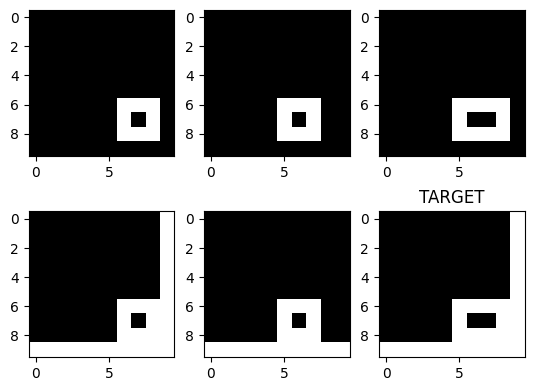

In [4]:
print(method_index[5])
plot_double_trio(nonduplicates[5])

In [5]:
# Split into input (x) and output (y)
x_data = nonduplicates[:, :-1, :, :] / 255 # All but the last channel
y_data = nonduplicates[:, -1, :, :] / 255  # Only the last channel
x_data = torch.from_numpy(x_data).float()
y_data = torch.from_numpy(y_data).float()
x_train, x_test, y_train, y_test, methods_train, methods_test = train_test_split(x_data, y_data, method_index, test_size=rel_test_size, random_state=42)
print(f"x_train: {x_train.shape},\ny_train: {y_train.shape},\nx_test: {x_test.shape},\ny_test: {y_test.shape}")
print(f"train methods: {methods_train[0:3]}")
print(f"test methods: {methods_test[0:3]}")
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_train: torch.Size([1088728, 5, 10, 10]),
y_train: torch.Size([1088728, 10, 10]),
x_test: torch.Size([10998, 5, 10, 10]),
y_test: torch.Size([10998, 10, 10])
train methods: ['Shadows' 'Close_Far Corners' 'Shadows']
test methods: ['Rotated' 'Count' 'Moved']


In [6]:
%%capture
if train_new_model and log_wandb:
    from datetime import datetime

    # Get current date and time
    current_datetime = datetime.now()

    # Format the datetime object as a string
    current_datetime_string = current_datetime.strftime("%Y-%m-%d %H")

    wandb.init(
        project="simpleARC",
        name = f"{shape}_{current_datetime_string}",
        config={
        
        "architecture": FullyConnectedNN,
        "shape": shape,
        "img_size": img_size,
        "pairs_per_task": pairs_per_task,
        "analogies": method_names,
        "epochs": num_epochs,
        "learning_rate": learning_rate,
        "use_lr_scheduler": use_lr_scheduler,
        "rel_test_size": rel_test_size,
        "num_samples": num_samples
        })

In [7]:
torch.manual_seed(42)
if train_new_model:
    model = FullyConnectedNN().to(device)
    print(f"Nr params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=num_epochs, verbose=True)

    for epoch in range(num_epochs):
        for (inputs, labels) in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model.train()
            optimizer.zero_grad()
            train_outputs = model(inputs)
            loss = criterion(train_outputs, labels)
            loss.backward()
            optimizer.step()
        if use_lr_scheduler:
            scheduler.step()

        test_metrics = get_test_metrics(x_test, y_test, model, criterion, methods_test, True)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Test: {test_metrics["test loss"]:.4f}, %solved: {test_metrics["percent_solved"]:.2f}')
        if log_wandb:
            wandb.log({"epoch": epoch + 1, "train Loss": loss.item()} | test_metrics)

    torch.save(model.state_dict(), f'model_trained_on_{shape}.pth')
else:
    model = FullyConnectedNN()
    model.load_state_dict(torch.load(f'model_trained_on_{shape}.pth'))

Nr params: 200700
Epoch [1/60], Loss: 0.0936, Test: 0.0851, %solved: 20.80
Epoch [2/60], Loss: 0.0493, Test: 0.0503, %solved: 36.29
Epoch [3/60], Loss: 0.0307, Test: 0.0340, %solved: 48.35
Epoch [4/60], Loss: 0.0271, Test: 0.0245, %solved: 57.46
Epoch [5/60], Loss: 0.0196, Test: 0.0197, %solved: 63.22
Epoch [6/60], Loss: 0.0123, Test: 0.0167, %solved: 68.75
Epoch [7/60], Loss: 0.0182, Test: 0.0141, %solved: 72.80
Epoch [8/60], Loss: 0.0091, Test: 0.0123, %solved: 76.90
Epoch [9/60], Loss: 0.0090, Test: 0.0106, %solved: 78.86
Epoch [10/60], Loss: 0.0076, Test: 0.0103, %solved: 80.18
Epoch [11/60], Loss: 0.0115, Test: 0.0098, %solved: 81.11
Epoch [12/60], Loss: 0.0097, Test: 0.0097, %solved: 81.69
Epoch [13/60], Loss: 0.0055, Test: 0.0084, %solved: 85.01
Epoch [14/60], Loss: 0.0061, Test: 0.0091, %solved: 83.98
Epoch [15/60], Loss: 0.0078, Test: 0.0084, %solved: 83.30
Epoch [16/60], Loss: 0.0059, Test: 0.0077, %solved: 86.92
Epoch [17/60], Loss: 0.0050, Test: 0.0071, %solved: 87.02
Epoch

Test set example:


<Figure size 1200x400 with 0 Axes>

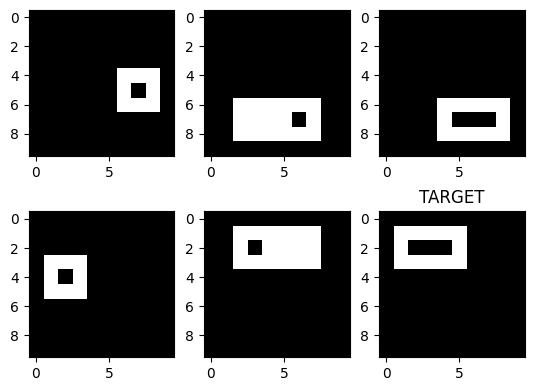

Prediction:


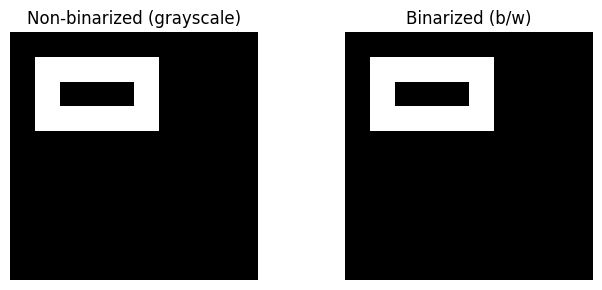

Most similar training case:


<Figure size 1200x400 with 0 Axes>

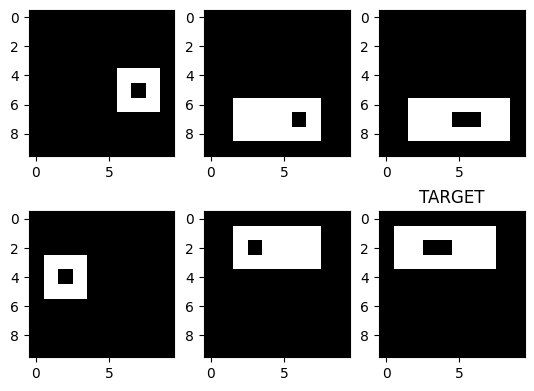

In [8]:
plot_exmp = 0
with torch.inference_mode():
    print("Test set example:")
    y  = y_test[plot_exmp].expand(1, y_test[plot_exmp].shape[0], y_test[plot_exmp].shape[1])
    example = torch.row_stack((x_test[plot_exmp], y))
    plot_double_trio(example)

    print("Prediction:")
    tensor = model(x_test[plot_exmp].unsqueeze(0))[0]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns
    axs[0].set_title("Non-binarized (grayscale)")
    axs[0].imshow(tensor, cmap='gray')
    axs[0].axis('off')
    axs[1].set_title("Binarized (b/w)")
    axs[1].imshow(torch.round(tensor), cmap='gray')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()
    
    print("Most similar training case:")
    distances = [torch.sum(torch.abs(x_test[plot_exmp] - np.array(x_train[i]))).item() for i in range(x_train.shape[0])]
    sim_index = np.argmin(distances)
    y  = y_train[sim_index].expand(1, y_train[sim_index].shape[0], y_train[sim_index].shape[1])
    plot_double_trio(torch.row_stack((x_train[sim_index], y)))

In [9]:
#predict on all shapes (e.g. differently shaped figures)
for test_shape in ["I", "L", "O", "T"]:
    with open(f"nonduplicates_{test_shape}.pkl", "rb") as f:
        added_test_data = pickle.load(file=f)
    with open(f"method_index_{test_shape}.pkl", "rb") as f:
        methods_from_added_data = pickle.load(file=f)
    added_x_data = added_test_data[:, :-1, :, :] / 255 # All but the last channel
    added_y_data = added_test_data[:, -1, :, :] / 255  # Only the last channel
    added_x_data = torch.from_numpy(added_x_data).float()
    added_y_data = torch.from_numpy(added_y_data).float()
    metrics = get_test_metrics(added_x_data, added_y_data, model, nn.BCELoss(), methods_from_added_data, True)
    print(metrics)
    if log_wandb:
        wandb.log({f"{test_shape}_{key}": value for key, value in metrics.items()})

{'test loss': 1.4295101165771484, 'percent_solved': 29.474641304940807, 'Close_Far Corners': 43.84038403840384, 'Close_Far Edges': 24.152173695632605, 'Count': 3.5292117527051623, 'Gravity': 17.02602156129368, 'Grown': 26.900345017250864, 'Inverted': 44.87677042490198, 'Mirrored': 46.49268517221366, 'Moved': 36.24226180356232, 'Rotated': 47.51727655488994, 'Shadows': 18.758250990118814, 'Stretched': 14.896575178042731}
{'test loss': 1.1722663640975952, 'percent_solved': 13.932454545454545, 'Close_Far Corners': 13.828999999999999, 'Close_Far Edges': 7.866, 'Count': 8.665000000000001, 'Gravity': 2.513, 'Grown': 6.938, 'Inverted': 17.506, 'Mirrored': 20.951, 'Moved': 14.27, 'Rotated': 24.771, 'Shadows': 17.52, 'Stretched': 18.428}
{'test loss': 0.0020985547453165054, 'percent_solved': 96.56423509128638, 'Close_Far Corners': 99.14778694673669, 'Close_Far Edges': 97.60849778453475, 'Count': 93.64930142315654, 'Gravity': 94.5075056755108, 'Grown': 96.82558732635242, 'Inverted': 98.5383130071

Example from additional dataset:


<Figure size 1200x400 with 0 Axes>

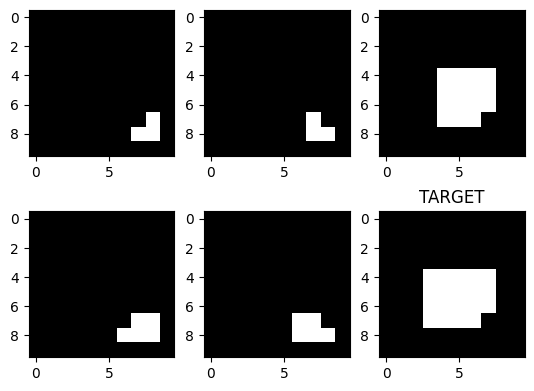

Prediction:


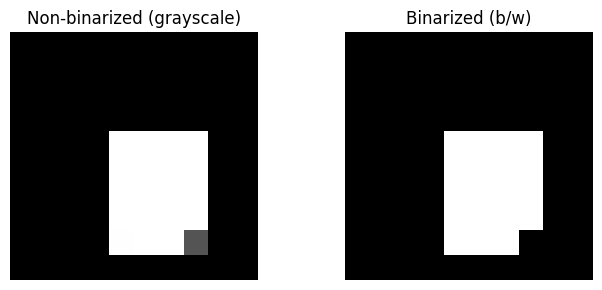

In [10]:
#inspect prediction on other datafile (e.g. differently shaped figures)
test_shape = "L"
with open(f"nonduplicates_{test_shape}.pkl", "rb") as f:
    added_test_data = pickle.load(file=f)
with open(f"method_index_{test_shape}.pkl", "rb") as f:
    methods_from_added_data = pickle.load(file=f)
added_x_data = added_test_data[:, :-1, :, :] / 255 # All but the last channel
added_y_data = added_test_data[:, -1, :, :] / 255  # Only the last channel
added_x_data = torch.from_numpy(added_x_data).float()
added_y_data = torch.from_numpy(added_y_data).float()
plot_exmp = 0
with torch.inference_mode():
    print("Example from additional dataset:")
    added_y  = added_y_data[plot_exmp].expand(1, added_y_data[plot_exmp].shape[0], added_y_data[plot_exmp].shape[1])
    example = torch.row_stack((added_x_data[plot_exmp], added_y))
    plot_double_trio(example)
    print("Prediction:")
    tensor = model(added_x_data[plot_exmp].unsqueeze(0))[0]
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns
    axs[0].set_title("Non-binarized (grayscale)")
    axs[0].imshow(tensor, cmap='gray')
    axs[0].axis('off')
    axs[1].set_title("Binarized (b/w)")
    axs[1].imshow(torch.round(tensor), cmap='gray')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()